In [1]:
import modin.pandas as pd
from tqdm.auto import tqdm

from modin.config import ProgressBar
ProgressBar.enable()

In [2]:
wforms = pd.read_parquet("tokens.parquet", columns=["doy", "wforms_new"])
wforms = wforms[wforms["wforms_new"].map(len) > 0]
wforms = wforms.explode("wforms_new").rename(columns={"wforms_new": "wf"})

annotations = pd.read_parquet("wforms-ann.parquet")
annotations = annotations[annotations["status"] > 0]
wforms = wforms.join(annotations, on="wf", how="inner")

tweets_geo = pd.read_parquet("tweets-geo.parquet")
tweets_geo = tweets_geo[tweets_geo["country_code"] == "IT"]
wforms = wforms.join(tweets_geo, how="inner")

wforms = wforms[["doy", "wf", "reg_istat_code"]]

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2023-07-22 10:06:27,067	INFO worker.py:1636 -- Started a local Ray instance.


Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 9:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 10:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 11:   0%           Elapsed time: 00:00, estimated remaining time: ?

In [3]:
import geopandas as gpd

regions = gpd.read_file(
    filename=r"https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_regions.geojson"
)
regions.set_index("reg_istat_code", inplace=True)
regions.drop(columns=["reg_name", "reg_istat_code_num"], inplace=True)

In [4]:
choros = (
    wforms.groupby(["wf", "reg_istat_code"], dropna=False)
    .size()
    .reset_index(name="count")
    .merge(pd.DataFrame(regions), on="reg_istat_code", how="left")
)

choros = gpd.GeoDataFrame(choros._to_pandas())

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Exception in thread Thread-41 (call_progress_bar):
Traceback (most recent call last):
  File "/opt/share/spack/spack-0.19.1/opt/spack/linux-ubuntu22.04-x86_64/gcc-12.1.0/python-3.10.8-qkx5vsyopsbqtvrf6y2bf7aviocikm4m/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/share/spack/spack-0.19.1/opt/spack/linux-ubuntu22.04-x86_64/gcc-12.1.0/python-3.10.8-qkx5vsyopsbqtvrf6y2bf7aviocikm4m/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/clusterusers/pbrasolin_eurac/jupyter/lib/python3.10/site-packages/modin/core/execution/modin_aqp.py", line 61, in call_progress_bar
    futures = [
  File "/home/clusterusers/pbrasolin_eurac/jupyter/lib/python3.10/site-packages/modin/core/execution/modin_aqp.py", line 61, in <listcomp>
    futures = [
TypeError: 'PandasOnRayDataframePartition' object is not iterable


Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

  0%|          | 0/224 [00:00<?, ?it/s]

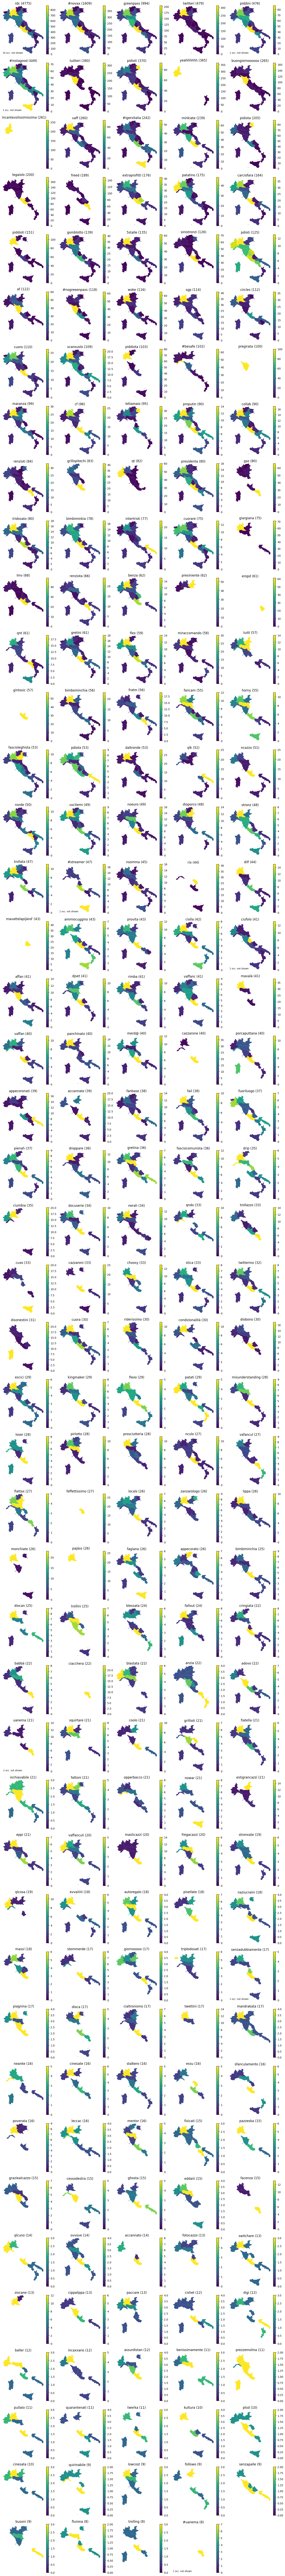

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sums = choros.groupby("wf")["count"].sum().to_dict()

sorted_wf = choros.groupby("wf").sum("count")["count"].sort_values(ascending=False)
sorted_choros = choros.set_index("wf").loc[sorted_wf.index].reset_index()


def annotate(data, pbar=None, **kws):
    if pbar:
        pbar.update(1)
    wf = data["wf"].iloc[0]
    ax = plt.gca()
    data.plot(
        column="count",
        ax=ax,
        legend=True,
        cmap="viridis",
        vmin=0,
    )
    ax.set_title("{} ({})".format(wf, sums[wf]))
    nd = data[data["reg_istat_code"].isna()]["count"].sum()
    if nd:
        ax.text(
            0,
            0,
            "{} occ. not shown".format(nd),
            transform=ax.transAxes,
            fontsize="small",
        )


fg = sns.FacetGrid(
    sorted_choros,#.head(200),
    col="wf",
    col_wrap=5,
    height=3,
    # Actual boundaries
    # xlim=(6.6272658, 18.7844746),
    # ylim=(35.2889616, 47.0921462),
    # Skip islands for tighter layout
    xlim=(6.616667, 18.516667),
    ylim=(36.688444, 47.083333),
)

fg.set(xticks=[], yticks=[])
sns.despine(bottom=True, left=True)

# TODO: parallelize this
with tqdm(total=len(sums)) as pbar:
    fg.map_dataframe(annotate, pbar=pbar)

plt.show()